# Race Around the Netherlands 

Who are tougher: men or women?
Are riders that ride together more or less likely to finish?
How does rainfall and windspeed affect percentage of riders that drop out of the race?

In [56]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime
%matplotlib inline

import pymysql
from sqlalchemy import create_engine

### CSV's to MYSQL-tables

In [13]:
riders = pd.read_csv('./data/all_riders.csv')

In [3]:
weather = pd.read_csv('./data/weather_excl_wind_dir.csv')

In [146]:
engine = 'mysql+pymysql://root:123KLM@%GFDhello@localhost/ironhack_project2'

In [143]:
riders.to_sql("riders", engine) # I already started working from the CSV, so proof of principle, but will continue with CSV
weather.to_sql("weather", engine) 

In [148]:
riders_sql = pd.read_sql_query('SELECT * FROM ironhack_project2.riders', engine)
riders_sql.head()

,index,Unnamed: 0,Unnamed: 0.1,Place,Firstname,Lastname,Gender,Solo or Duo,Status,StartDate,Checkpoint_1,Checkpoint_2,Checkpoint_3,Checkpoint_4,Checkpoint_5,Checkpoint_6,Checkpoint_7,Checkpoint_8,Checkpoint_9,Checkpoint_fin
0,0,0,0,1,Joris,Cosyn,male,Solo,Finisher,2018-05-01 08:00:00,2018-05-01 13:38:00,2018-05-02 01:17:00,2018-05-02 05:22:00,2018-05-02 10:22:00,2018-05-02 16:02:00,2018-05-03 06:28:00,2018-05-03 11:36:00,2018-05-04 05:54:00,2018-05-04 19:20:00,2018-05-05 14:24:00
1,1,1,1,2,Tjerk,Bakker,male,Solo,Finisher,2018-05-01 08:00:00,2018-05-01 14:35:00,2018-05-02 09:15:00,2018-05-02 13:17:00,empty,2018-05-03 07:01:00,2018-05-03 14:34:00,2018-05-03 19:30:00,2018-05-04 16:03:00,2018-05-05 08:59:00,2018-05-05 18:48:00
2,2,2,2,3,Colin,James,male,Solo,Finisher,2018-05-01 08:00:00,2018-05-01 14:08:00,2018-05-02 08:32:00,2018-05-02 11:53:00,2018-05-02 16:51:00,2018-05-03 04:11:00,2018-05-03 12:32:00,2018-05-03 17:34:00,2018-05-04 12:10:00,2018-05-05 07:54:00,2018-05-05 19:22:00
3,3,3,3,4,Jason,Schreurs,male,Solo,Finisher,2018-05-01 08:00:00,2018-05-01 13:27:00,2018-05-02 10:08:00,2018-05-02 12:52:00,2018-05-02 17:36:00,2018-05-03 08:16:00,2018-05-03 14:51:00,2018-05-03 19:30:00,2018-05-04 16:35:00,2018-05-05 11:05:00,2018-05-05 21:30:00
4,4,4,4,5,Erik,Wallinga,male,Solo,Finisher,2018-05-01 08:00:00,2018-05-01 14:25:00,2018-05-02 04:13:00,2018-05-02 07:50:00,2018-05-02 13:42:00,2018-05-02 20:00:00,2018-05-03 14:13:00,2018-05-03 18:40:00,2018-05-04 20:22:00,2018-05-05 09:53:00,2018-05-05 22:39:00


### Drop unnecessary columns and rows

The corona crisis affected which riders could travel to The Netherlands and were therefore able to show up at the start. In 2021 corona still played a role. Therefore we will not analyze riders that did not start (DNS). These can be removed from the file.

Also, columns: <i> Unnamed: 0 </i> and <i> Unnamed: 0.1 </i> can be removed.

In [308]:
riders.head(2)

,Unnamed: 0,Unnamed: 0.1,Place,Firstname,Lastname,Gender,Solo or Duo,Status,StartDate,Checkpoint_1,Checkpoint_2,Checkpoint_3,Checkpoint_4,Checkpoint_5,Checkpoint_6,Checkpoint_7,Checkpoint_8,Checkpoint_9,Checkpoint_fin
0,0,0,1,Joris,Cosyn,male,Solo,Finisher,2018-05-01 08:00:00,2018-05-01 13:38:00,2018-05-02 01:17:00,2018-05-02 05:22:00,2018-05-02 10:22:00,2018-05-02 16:02:00,2018-05-03 06:28:00,2018-05-03 11:36:00,2018-05-04 05:54:00,2018-05-04 19:20:00,2018-05-05 14:24:00
1,1,1,2,Tjerk,Bakker,male,Solo,Finisher,2018-05-01 08:00:00,2018-05-01 14:35:00,2018-05-02 09:15:00,2018-05-02 13:17:00,empty,2018-05-03 07:01:00,2018-05-03 14:34:00,2018-05-03 19:30:00,2018-05-04 16:03:00,2018-05-05 08:59:00,2018-05-05 18:48:00


In [14]:
#drop columns
riders = riders.drop(["Unnamed: 0", "Unnamed: 0.1"], axis = 1)

# delete rows of riders that did not start (status: DNS)
riders = riders[riders.Status != "DNS"]

In [16]:
riders.tail(5)

,Place,Firstname,Lastname,Gender,Solo or Duo,Status,StartDate,Checkpoint_1,Checkpoint_2,Checkpoint_3,Checkpoint_4,Checkpoint_5,Checkpoint_6,Checkpoint_7,Checkpoint_8,Checkpoint_9,Checkpoint_fin
304,2,NaN,van Rijswijk - van den Broek,mixed,Duo,Finisher,2021-04-30 08:15:00,2021-04-30 15:30:00,2021-05-01 16:16:00,2021-05-01 19:55:00,2021-05-02 16:42:00,2021-05-03 13:18:00,2021-05-05 09:40:00,2021-05-05 16:27:00,2021-05-07 13:39:00,2021-05-08 11:55:00,2021-05-09 15:30:00
305,999,NaN,Cullen - Driedonks,male,Duo,DNF,2021-05-01 06:15:00,2021-05-01 12:40:00,2021-05-02 00:59:00,2021-05-02 04:17:00,2021-05-02 18:46:00,empty,empty,empty,empty,empty,empty
306,999,NaN,Harder - Joosten,male,Duo,DNF,2021-04-30 08:15:00,2021-04-30 15:17:00,2021-05-01 11:53:00,2021-05-01 16:03:00,2021-05-02 11:59:00,2021-05-02 21:57:00,empty,empty,empty,empty,empty
307,999,NaN,Bisschops - Wiegel,mixed,Duo,DNF,2021-04-30 06:30:00,2021-04-30 13:53:00,2021-05-01 11:39:00,2021-05-01 16:00:00,2021-05-02 10:25:00,2021-05-02 21:13:00,empty,empty,empty,empty,empty
308,999,NaN,Verweij - Hoskam,mixed,Duo,DNF,2021-04-30 08:15:00,2021-04-30 14:27:00,2021-05-01 12:38:00,2021-05-01 15:38:00,2021-05-02 11:14:00,empty,empty,empty,empty,empty,empty


### Calculate after how many checkpoints the riders that did not finish dropped

In [17]:
pd.set_option('display.max_rows', riders.shape[0]+1)
riders = riders.reset_index()

In [18]:
#add a column that counts after how many checkpoints a rider gave up (if he/she did)

# find out at which checkpoint the rider is last seen and put that in a list which will be appended to the riders dataframe.
# find out at which data/time the rider is last seen and put that in a list which will be appended to the riders dataframe.  

count = [] #checkpoint the riders is last seen (start = 0)
last_time = [] #last datetime that is noted for the riders

for i in range(len(riders)):
    if riders["Checkpoint_fin"][i] != "empty": #these riders finished the ride
        left_race = 10
        count.append(left_race)
        time = riders["Checkpoint_fin"][i]
        last_time.append(time)
#        print(f'great news at {[i]}', left_race)
    elif riders["Checkpoint_9"][i] != "empty":
        left_race = 9
        count.append(left_race)
        time = riders["Checkpoint_9"][i]
        last_time.append(time)
#        print(f'great news at {[i]}', left_race)
    elif riders["Checkpoint_8"][i] != "empty":
        left_race = 8
        count.append(left_race)
        time = riders["Checkpoint_8"][i]
        last_time.append(time)
#        print(f'great news at {[i]}', left_race)
    elif riders["Checkpoint_7"][i] != "empty":
        left_race = 7
        count.append(left_race)
        time = riders["Checkpoint_7"][i]
        last_time.append(time)
#        print(f'great news at {[i]}', left_race)
    elif riders["Checkpoint_6"][i] != "empty":
        left_race = 6 
        count.append(left_race)
        time = riders["Checkpoint_6"][i]
        last_time.append(time)
#        print(f'great news at {[i]}', left_race)
    elif riders["Checkpoint_5"][i] !="empty":
        left_race = 5
        count.append(left_race)
        time = riders["Checkpoint_5"][i]
        last_time.append(time)
#        print(f'great news at {[i]}', left_race)
    elif riders["Checkpoint_4"][i] != "empty":
        left_race = 4
        count.append(left_race)
        time = riders["Checkpoint_4"][i]
        last_time.append(time)
#        print(f'great news at {[i]}', left_race)
    elif riders["Checkpoint_3"][i] != "empty":
        left_race = 3
        count.append(left_race)
        time = riders["Checkpoint_3"][i]
        last_time.append(time)
#        print(f'great news at {[i]}', left_race)
    elif riders["Checkpoint_2"][i] != "empty":
        left_race = 2
        count.append(left_race)
        time = riders["Checkpoint_2"][i]
        last_time.append(time)
#        print(f'great news at {[i]}', left_race)
    elif riders["Checkpoint_1"][i] != "empty":
        left_race = 1
        count.append(left_race)
        time = riders["Checkpoint_1"][i]
        last_time.append(time)
#       print(f'great news at {[i]}', left_race)
    elif riders["Checkpoint_1"][i] == "empty":
        left_race = 0
        count.append(left_race)
        time = riders["StartDate"][i]
        last_time.append(time)
#        print(f'great news at {[i]}', left_race)
    else:
        print(f'problem at line {[i]}')       


In [19]:
# last_time 

In [20]:
riders["Last_seen_place"] = count
riders["Last_seen_date"] = last_time

In [77]:
riders.head(52)

,index,Place,Firstname,Lastname,Gender,Solo or Duo,Status,StartDate,Checkpoint_1,Checkpoint_2,...,Checkpoint_5,Checkpoint_6,Checkpoint_7,Checkpoint_8,Checkpoint_9,Checkpoint_fin,Last_seen_place,Last_seen_date,Race_time,Race_time_sec
0,0,1,Joris,Cosyn,male,Solo,Finisher,2018-05-01 08:00:00,2018-05-01 13:38:00,2018-05-02 01:17:00,...,2018-05-02 16:02:00,2018-05-03 06:28:00,2018-05-03 11:36:00,2018-05-04 05:54:00,2018-05-04 19:20:00,2018-05-05 14:24:00,10,2018-05-05 14:24:00,4 days 06:24:00,368640.0
1,1,2,Tjerk,Bakker,male,Solo,Finisher,2018-05-01 08:00:00,2018-05-01 14:35:00,2018-05-02 09:15:00,...,2018-05-03 07:01:00,2018-05-03 14:34:00,2018-05-03 19:30:00,2018-05-04 16:03:00,2018-05-05 08:59:00,2018-05-05 18:48:00,10,2018-05-05 18:48:00,4 days 10:48:00,384480.0
2,2,3,Colin,James,male,Solo,Finisher,2018-05-01 08:00:00,2018-05-01 14:08:00,2018-05-02 08:32:00,...,2018-05-03 04:11:00,2018-05-03 12:32:00,2018-05-03 17:34:00,2018-05-04 12:10:00,2018-05-05 07:54:00,2018-05-05 19:22:00,10,2018-05-05 19:22:00,4 days 11:22:00,386520.0
3,3,4,Jason,Schreurs,male,Solo,Finisher,2018-05-01 08:00:00,2018-05-01 13:27:00,2018-05-02 10:08:00,...,2018-05-03 08:16:00,2018-05-03 14:51:00,2018-05-03 19:30:00,2018-05-04 16:35:00,2018-05-05 11:05:00,2018-05-05 21:30:00,10,2018-05-05 21:30:00,4 days 13:30:00,394200.0
4,4,5,Erik,Wallinga,male,Solo,Finisher,2018-05-01 08:00:00,2018-05-01 14:25:00,2018-05-02 04:13:00,...,2018-05-02 20:00:00,2018-05-03 14:13:00,2018-05-03 18:40:00,2018-05-04 20:22:00,2018-05-05 09:53:00,2018-05-05 22:39:00,10,2018-05-05 22:39:00,4 days 14:39:00,398340.0
5,5,6,Ralph,Cullen,male,Solo,Finisher,2018-05-01 08:00:00,2018-05-01 14:04:00,2018-05-02 06:54:00,...,2018-05-02 21:02:00,2018-05-03 08:01:00,2018-05-03 21:44:00,2018-05-04 15:58:00,2018-05-05 12:03:00,2018-05-06 06:34:00,10,2018-05-06 06:34:00,4 days 22:34:00,426840.0
6,6,7,Adam,Verhaar,male,Solo,Finisher,2018-05-01 08:00:00,2018-05-01 14:05:00,2018-05-02 11:40:00,...,2018-05-03 11:25:00,2018-05-03 18:19:00,2018-05-04 08:58:00,2018-05-05 09:27:00,2018-05-05 20:47:00,2018-05-06 16:23:00,10,2018-05-06 16:23:00,5 days 08:23:00,462180.0
7,7,8,James,Holmes,male,Solo,Finisher,2018-05-01 08:00:00,2018-05-01 14:34:00,2018-05-02 12:39:00,...,2018-05-03 12:40:00,2018-05-03 21:58:00,2018-05-04 11:19:00,2018-05-05 12:51:00,2018-05-06 07:42:00,2018-05-06 21:03:00,10,2018-05-06 21:03:00,5 days 13:03:00,478980.0
8,8,9,Jamie,Robison,male,Solo,Finisher,2018-05-01 08:00:00,2018-05-01 15:15:00,2018-05-02 17:50:00,...,2018-05-03 16:17:00,2018-05-04 11:34:00,2018-05-04 17:16:00,2018-05-05 18:05:00,2018-05-06 16:47:00,2018-05-07 12:13:00,10,2018-05-07 12:13:00,6 days 04:13:00,533580.0
9,9,10,Onno,Zuidema,male,Solo,Finisher,2018-05-01 08:00:00,2018-05-01 14:38:00,2018-05-02 18:11:00,...,2018-05-04 08:03:00,2018-05-04 15:58:00,2018-05-04 20:36:00,2018-04-29 07:48:00,2018-04-29 19:18:00,2018-04-30 16:47:00,10,2018-04-30 16:47:00,-1 days +08:47:00,-54780.0


### Time in race
Calculate for each rider the time he/she was in the race (at least). Use Last_seen_date and StartDate to create Race_time column.

In [22]:
riders['StartDate'] = pd.to_datetime(riders['StartDate'], format='%Y-%m-%d %H:%M:%S')
riders['Last_seen_date'] = pd.to_datetime(riders['Last_seen_date'], format='%Y-%m-%d %H:%M:%S')

In [76]:
riders["Race_time"] = riders["Last_seen_date"] - riders["StartDate"]
riders["Race_time"].sort_values(ascending=True) #SHIIIIT SOME CONVERSIONS WENT WRONG

74    -4 days +23:40:00
32    -3 days +12:56:00
21    -2 days +03:36:00
130   -2 days +07:52:00
131   -2 days +07:52:00
9     -1 days +08:47:00
10    -1 days +11:45:00
12    -1 days +15:57:00
124     0 days 00:00:00
269     0 days 00:00:00
103     0 days 05:36:00
89      0 days 05:41:00
104     0 days 05:55:00
264     0 days 06:09:00
129     0 days 06:16:00
128     0 days 06:18:00
265     0 days 06:20:00
87      0 days 06:32:00
20      0 days 07:08:00
193     0 days 07:08:00
266     0 days 07:22:00
267     0 days 07:34:00
72      0 days 07:38:00
268     0 days 08:29:00
105     0 days 08:34:00
16      0 days 09:56:00
205     0 days 19:40:00
82      0 days 21:18:00
85      1 days 00:13:00
81      1 days 01:18:00
251     1 days 02:21:00
76      1 days 03:02:00
260     1 days 04:41:00
261     1 days 04:49:00
254     1 days 05:43:00
90      1 days 05:54:00
88      1 days 05:58:00
23      1 days 06:02:00
255     1 days 06:23:00
203     1 days 07:17:00
73      1 days 07:32:00
256     1 days 0

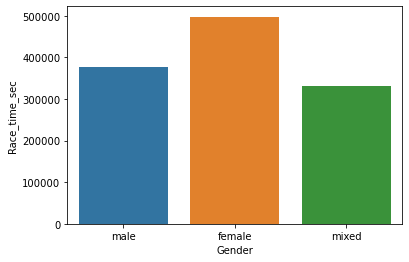

74    -260400.0
32    -212640.0
21    -159840.0
130   -144480.0
131   -144480.0
9      -54780.0
10     -44100.0
12     -28980.0
124         0.0
269         0.0
103     20160.0
89      20460.0
104     21300.0
264     22140.0
129     22560.0
128     22680.0
265     22800.0
87      23520.0
20      25680.0
193     25680.0
266     26520.0
267     27240.0
72      27480.0
268     30540.0
105     30840.0
16      35760.0
205     70800.0
82      76680.0
85      87180.0
81      91080.0
251     94860.0
76      97320.0
260    103260.0
261    103740.0
254    106980.0
90     107640.0
88     107880.0
23     108120.0
255    109380.0
203    112620.0
73     113520.0
256    114180.0
262    118500.0
257    119640.0
272    131460.0
100    136860.0
204    137160.0
91     140340.0
258    142380.0
71     156540.0
86     163620.0
83     170940.0
252    175800.0
75     175860.0
263    177420.0
206    177900.0
200    179940.0
275    183540.0
259    187920.0
201    189000.0
70     192420.0
102    193380.0
198    1

In [75]:
# type(riders["Race_time"][0]) #type: timedelta
# you cannot plot timedelta's, convert to seconds

riders["Race_time_sec"]= riders["Race_time"] / pd.Timedelta(seconds=1) #convert timedelta to seconds (float)
riders.head()
# type(riders["Race_time_sec"][0]) 


#riders.groupby('Gender')['Race_time_sec'].mean(numeric_only=False)

sns.barplot(x="Gender", y="Race_time_sec", data=riders, ci=None)
plt.show();
riders["Race_time_sec"].sort_values(ascending=True) #PROBLEM SEE CELL ABOVE: SOME CONVERSIONS WENT WRONG

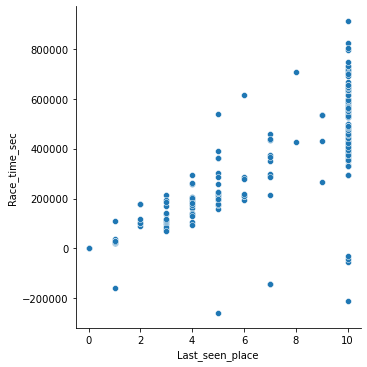

In [73]:
#scatterplot: hue = gender; individual

sns.relplot(x="Last_seen_place", y="Race_time_sec", data=riders)

# sns.lineplot(x="Race_time", y="signal",data=riders)

### Men versus women: speed

Men are usually faster than women, is this also true for the RATN-riders? for this analyses we look at the people that finished: who meets the finishline first?

        index  Place  Last_seen_place  Race_time_sec
Gender                                              
female    158     27               10       646560.0
male      148     16               10       525360.0
mixed     304      2               10       803700.0


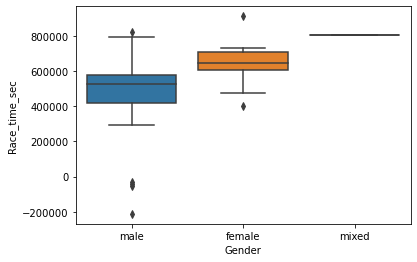

In [90]:
finishers = riders[riders.Status == "Finisher"] #dataframe with riders that did finish

print(finishers.groupby("Gender").median())

sns.boxplot(data=finishers, y="Race_time_sec", x="Gender")
plt.show()

        index  Place  Last_seen_place  Race_time_sec
Gender                                              
female     94    999                4       200820.0
male      136    999                4       175860.0
mixed     307    999                4       183540.0


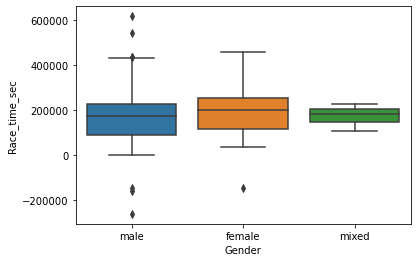

In [91]:
DNF = riders[riders.Status == "DNF"] #dataframe with all riders that did not finish

print(DNF.groupby("Gender").median())

sns.boxplot(data=DNF, y="Race_time_sec", x="Gender")
plt.show()

### distribution of drop outs
To see if there is a difference in distribution of dropouts, we first look at % DNF

In [191]:
finishers = riders[riders.Status == "Finisher"] #dataframe with riders that did finish
DNF = riders[riders.Status == "DNF"] #dataframe with all riders that did not finish

print(DNF.groupby("Gender").median()) #men and women drop most often after the 4th checkpoint (Somewhere after Harlingen and before Amsterdam)
print(DNF.groupby("Gender").std())
print(DNF.groupby("Gender").mean()) #the mean is higher for women, indicating that the distributions of men and women might differ

        index  Place  Last_seen
Gender                         
female     94    999          4
male      136    999          4
mixed     307    999          4
             index  Place  Last_seen
Gender                              
female   56.184221    0.0   2.225395
male     96.122374    0.0   2.198006
mixed   163.679565    0.0   2.081666
             index  Place  Last_seen
Gender                              
female  103.000000  999.0   4.571429
male    169.989247  999.0   3.924731
mixed   213.000000  999.0   3.333333


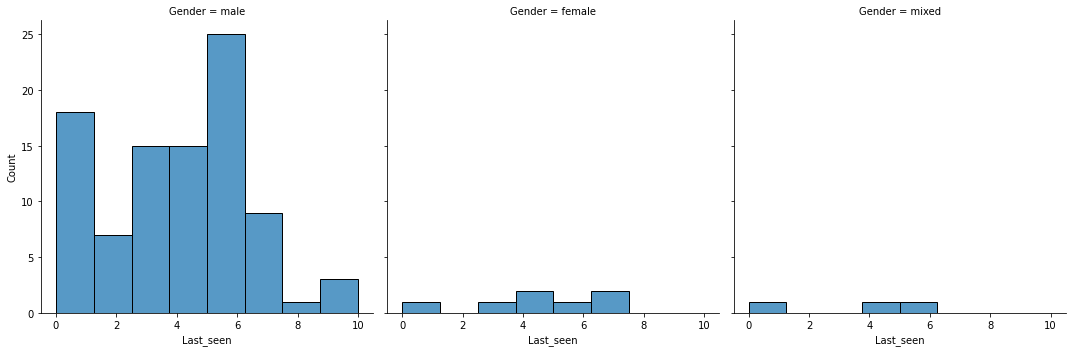

In [213]:
sns.displot(data=DNF, x="Last_seen", col="Gender", multiple = "dodge")

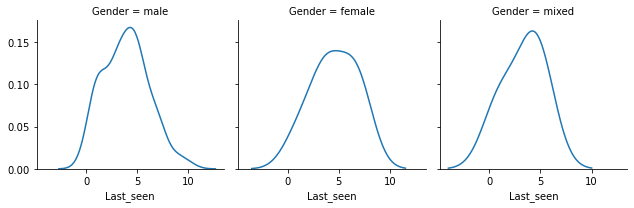

In [223]:
ns.FacetGrid(data = DNF, col = "Gender").map(sns.kdeplot, "Last_seen")

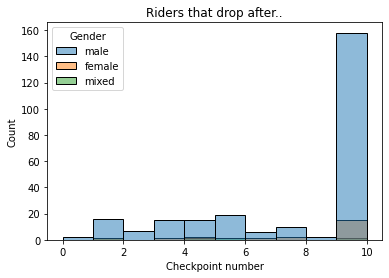

In [193]:
sns.histplot(x = "Last_seen", data=riders, hue = "Gender")
plt.title("Riders that drop after..")
plt.xlabel("Checkpoint number")
plt.show();

C:\Users\jetsa\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\jetsa\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\jetsa\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

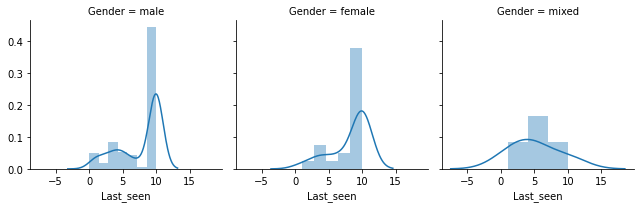

In [168]:
sns.FacetGrid(data = riders, col = "Gender").map(sns.distplot, "Last_seen")

# plt.title("Riders that drop after..")
# plt.xlabel("Checkpoint number")
plt.show();

In [341]:
# for i in range (len(riders)):
#     if riders["Checkpoint_1"][i] != "empty":
#         riders["Checkpoint_1"][i] = pd.to_datetime(riders["Checkpoint_1"][i], format = "%Y-%m-%d %H:%M:%S")

# for i in range (len(riders)):        
#     if riders["Checkpoint_2"][i] != "empty":
#         riders["Checkpoint_2"][i] =  pd.to_datetime(riders["Checkpoint_2"][i], format = "%Y-%m-%d %H:%M:%S")

# for i in range (len(riders)):
#     if riders["Checkpoint_3"][i] != "empty":
#         riders["Checkpoint_3"][i] =  pd.to_datetime(riders["Checkpoint_3"][i], format = "%Y-%m-%d %H:%M:%S")

# for i in range (len(riders)):
#     if riders["Checkpoint_4"][i] != "empty":
#         riders["Checkpoint_4"][i] =  pd.to_datetime(riders["Checkpoint_4"][i], format = "%Y-%m-%d %H:%M:%S")

# for i in range (len(riders)):
#     if riders["Checkpoint_5"][i] != "empty":
#         riders["Checkpoint_5"][i] = pd.to_datetime(riders["Checkpoint_5"][i], format = "%Y-%m-%d %H:%M:%S")

# for i in range (len(riders)):
#     if riders["Checkpoint_6"][i] != "empty":
#         riders["Checkpoint_6"][i] =  pd.to_datetime(riders["Checkpoint_6"][i], format = "%Y-%m-%d %H:%M:%S")
    
# for i in range (len(riders)):
#     if riders["Checkpoint_7"][i] != "empty":
#         riders["Checkpoint_7"][i] =  pd.to_datetime(riders["Checkpoint_7"][i], format = "%Y-%m-%d %H:%M:%S")

# for i in range (len(riders)):
#     if riders["Checkpoint_8"][i] != "empty":
#         riders["Checkpoint_8"][i] =  pd.to_datetime(riders["Checkpoint_8"][i], format = "%Y-%m-%d %H:%M:%S")

# for i in range (len(riders)):
#     if riders["Checkpoint_9"][i] != "empty":
#         riders["Checkpoint_9"][i] =  pd.to_datetime(riders["Checkpoint_9"][i], format = "%Y-%m-%d %H:%M:%S")

# for i in range (len(riders)):
#     if riders["Checkpoint_fin"][i] != "empty":
#         riders["Checkpoint_fin"][i] =  pd.to_datetime(riders["Checkpoint_fin"][i], format = "%Y-%m-%d %H:%M:%S")
